### Tutorial 4 - How Create an Agnostic Pipeline

In this tutorial, we will show you how convert a simple code structure into a advanced and agnostic pipeline based on DAGs.

For this, we still can use the **Tutorial 1** with a simple Machine Learning script. There we use `make_blobs` to generate a dataset and them we cluster it using two algorithms: KMeans and SOM.

First, let's generate and save our data (you can use DASF or Scikit-learn). The objective here is just to generate some labeled data and use the `DatasetLabeled` as an example.

In [1]:
import numpy as np

from dasf.datasets import make_blobs

n_samples = 500000
n_bins = 3

# Generate 3 blobs with 2 classes where the second blob contains
# half positive samples and half negative samples. Probability in this
# blob is therefore 0.5.
centers = [(-6, -6), (0, 0), (9, 1)]
X, y = make_blobs(n_samples=n_samples, centers=centers, shuffle=False, random_state=42)

np.save("X.npy", X)
np.save("y.npy", y)

Now, let's import our `DatasetLabeled` and assign each file to the respective type.

In [2]:
from dasf.datasets import DatasetArray
from dasf.datasets import DatasetLabeled


class MyMakeBlobs(DatasetLabeled):
    def __init__(self):
        super().__init__(name="My Own make_blobs()", download=False)
        
        # Let's assign the train and val data.
        self._train = DatasetArray(name="X", download=False, root="X.npy")
        self._val = DatasetArray(name="y", download=False, root="y.npy")

make_blobs = MyMakeBlobs()

To reduce the variability and as an example, we can normalize the data to help the algorithms to fit better.

In [3]:
from dasf.transforms import Normalize

normalize = Normalize()

After, creating our dataset and the normalization transformation, we can start the executor. For this example, we can use Dask.

In [4]:
from dasf.pipeline.executors import DaskPipelineExecutor

dask = DaskPipelineExecutor(local=True)

2022-10-02 01:31:53,167 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-41q8cz3m', purging
2022-10-02 01:31:53,167 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-xokbnpvc', purging
2022-10-02 01:31:53,168 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-mpyzht0m', purging
2022-10-02 01:31:53,168 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-c1r1m7sj', purging


Now, it is time to create our pipeline objects. We can copy and paste the same code used previously.

In [5]:
from dasf.ml.cluster import KMeans
from dasf.ml.cluster import SOM

kmeans = KMeans(n_clusters=3, max_iter=100)
som = SOM(x=1, y=3, input_len=2, num_epochs=100)

Then, we generate the pipeline and connect all the pieces in one single DAG.

Pay attention that we are passing the our fresh executor `dask` to the pipeline by specifying the parameter `executor=`.

To connect all the objects, we use the function `add()` that returns the pipeline itself. The function inputs can be refered as an argument.

At the end, we can visualize the DAG using `visualize()` method. It will plot a image that represents the graph. Let's use one single line to do everything. It should be simple and easy to understand.

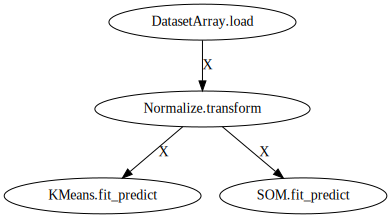

In [6]:
from dasf.pipeline import Pipeline

pipeline = Pipeline("A KMeans and SOM Pipeline", executor=dask)

pipeline.add(normalize, X=make_blobs._train) \
        .add(kmeans.fit_predict, X=normalize) \
        .add(som.fit_predict, X=normalize) \
        .visualize()

It is time to run our new pipeline.

In [7]:
%time pipeline.run()

[2022-10-02 01:31:53-0300] INFO - Beginning pipeline run for 'A KMeans and SOM Pipeline'
[2022-10-02 01:31:53-0300] INFO - Task 'DatasetArray.load': Starting task run...
[2022-10-02 01:31:53-0300] INFO - Task 'DatasetArray.load': Finished task run
[2022-10-02 01:31:53-0300] INFO - Task 'Normalize.transform': Starting task run...
[2022-10-02 01:31:53-0300] INFO - Task 'Normalize.transform': Finished task run
[2022-10-02 01:31:53-0300] INFO - Task 'KMeans.fit_predict': Starting task run...


/usr/local/lib/python3.8/dist-packages/dask/base.py:1365: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


[2022-10-02 01:32:00-0300] INFO - Task 'KMeans.fit_predict': Finished task run
[2022-10-02 01:32:00-0300] INFO - Task 'SOM.fit_predict': Starting task run...
[2022-10-02 01:32:18-0300] INFO - Task 'SOM.fit_predict': Finished task run
[2022-10-02 01:32:18-0300] INFO - Pipeline run successfully
CPU times: user 4.46 s, sys: 898 ms, total: 5.36 s
Wall time: 24.3 s


Notice that our pipeline returns two methods instead of one. To capture the result of some node, you can easily pass the same function or object to the pipeline function `get_result_from()`.

In [ ]:
result_kmeans = pipeline.get_result_from(kmeans.fit_predict).compute()
result_som = pipeline.get_result_from(som.fit_predict).compute()

In [ ]:
import numpy as np

from itertools import cycle

from matplotlib import cm
import matplotlib.pyplot as plt

def plot_results(X, result):
    y_unique = np.unique(result)
    
    colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    
    for this_y, color in zip(y_unique, colors):
        this_X = X[result == this_y]
        plt.scatter(
            this_X[:, 0],
            this_X[:, 1],
            s=50,
            c=color[np.newaxis, :],
            alpha=0.5,
            edgecolor="k",
            label="Class %s" % this_y,
        )

plot_results(make_blobs._train, result_kmeans)